In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST/", one_hot=True)

Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [12]:
# Training Param
num_steps = 70000
batch_size = 128
learning_rate = 2e-4

# network parameters
image_dim = 784 # 28 * 28 piexls
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # noise data points

# a custom initialization (see xavier glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [16]:
# store the weights and biases
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),   
}

biases = {
    'gen_hidden1': tf.Variable(glorot_init([gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

In [18]:
# generator
def generator(x):
    hidden_layer = tf.add(tf.matmul(x, weights['gen_hidden1']),
                          biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.add(tf.matmul(hidden_layer, weights['gen_out']),
                       biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# discriminator
def discriminator(x):
    hidden_layer = tf.add(tf.matmul(x, weights['disc_hidden1']),
                          biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.add(tf.matmul(hidden_layer, weights['disc_out']),
                       biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# build network
# network input
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_noise')

# Build Generator Network
gen_sample = generator(gen_input)

# build 2 discriminator networks (one form noise input, one form generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

# Build loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# build optimizer
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# training variables for each optimizer
# by default, in tensorflow, all variables are updated by each optimizer, 
# so we need to pprecise for each one of them the specific variables to update.
# genrator network variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
           biases['gen_hidden1'], biases['gen_out']]
# discriminator network variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'], 
            biases['disc_hidden1'], biases['disc_out']]

# create traing operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# initialize the variables (i.e. assign the default value)
init = tf.global_variables_initializer()

In [20]:
# start training 
# start a new tf session
sess = tf.Session()

# Run the initializer
sess.run(init)

# training 
for i in range(1, num_steps+1):
    # prepare data
    # get the next batch of mnist data(only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    
    # train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    
    if i % 2000 == 0 or i == 1:
        print('Step %i, Genarator Loss: %f, Discriminator Loss: %f' %(i, gl,dl))

Step 1, Genarator Loss: 0.882297, Discriminator Loss: 1.305479
Step 2000, Genarator Loss: 5.068214, Discriminator Loss: 0.027987
Step 4000, Genarator Loss: 4.436724, Discriminator Loss: 0.040175
Step 6000, Genarator Loss: 4.156024, Discriminator Loss: 0.085066
Step 8000, Genarator Loss: 3.990620, Discriminator Loss: 0.147937
Step 10000, Genarator Loss: 3.733725, Discriminator Loss: 0.136505
Step 12000, Genarator Loss: 4.603708, Discriminator Loss: 0.061539
Step 14000, Genarator Loss: 3.813803, Discriminator Loss: 0.169923
Step 16000, Genarator Loss: 3.947875, Discriminator Loss: 0.123781
Step 18000, Genarator Loss: 3.765917, Discriminator Loss: 0.271116
Step 20000, Genarator Loss: 3.901262, Discriminator Loss: 0.286956
Step 22000, Genarator Loss: 3.424707, Discriminator Loss: 0.271475
Step 24000, Genarator Loss: 3.275628, Discriminator Loss: 0.297381
Step 26000, Genarator Loss: 3.101562, Discriminator Loss: 0.335851
Step 28000, Genarator Loss: 3.252343, Discriminator Loss: 0.286007
Ste

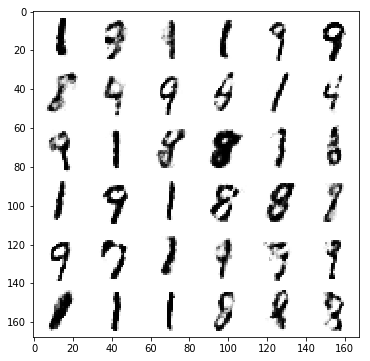

In [22]:
# testing
# genarate the image from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # generate image from noise
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    # reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # draw the generated image
        canvas[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = \
        g[j].reshape([28, 28])
        
plt.figure(figsize=(n, n))
plt.imshow(canvas, origin='upper', cmap='gray')
plt.show()